In [1]:
import torch
import pandas as pd
import numpy as np
import os
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from imblearn.over_sampling import SMOTE
from datasets import Dataset
from torch.utils.data import DataLoader
from torch.optim import AdamW
from transformers import AutoConfig
from transformers import AutoTokenizer, AutoModelForSequenceClassification, get_linear_schedule_with_warmup
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
url = "https://raw.githubusercontent.com/NafisNaufal/climate-change-sentiment-analysis/add-file-intern/cleaned_tweets.csv"
df_clean = pd.read_csv(url)

df_clean = df_clean.dropna(subset=['message', 'sentiment']).reset_index(drop=True)
df_clean = df_clean[df_clean['sentiment'] != 2].reset_index(drop=True)

train_df, test_df = train_test_split(df_clean, test_size=0.2, random_state=42, stratify=df_clean['sentiment'])

sentiments = df_clean['sentiment'].unique().tolist()
sentiment2id = {sentiment: i for i, sentiment in enumerate(sentiments)}
id2sentiment = {i: sentiment for i, sentiment in enumerate(sentiments)}

train_df['sentiment_encoded'] = train_df['sentiment'].map(sentiment2id)
test_df['sentiment_encoded'] = test_df['sentiment'].map(sentiment2id)

train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

In [3]:
df_clean

,message,sentiment
0,@tiniebeany climate change is an interesting h...,-1
1,"Watch #BeforeTheFlood right here, as @LeoDiCap...",1
2,Fabulous! Leonardo #DiCaprio's film on #climat...,1
3,Just watched this amazing documentary by leona...,1
4,Leonardo DiCaprio's climate change documentary...,0
...,...,...
30305,#AikBaatSuniThi \nGlobal warming has negative ...,1
30306,"Dear @realDonaldTrump,\nYeah right. Human Medi...",1
30307,What will your respective parties do to preven...,1
30308,i still cant believe this gif of taehyung save...,0


In [4]:
train_dataset, test_dataset

(Dataset({
     features: ['message', 'sentiment', 'sentiment_encoded', '__index_level_0__'],
     num_rows: 24248
 }),
 Dataset({
     features: ['message', 'sentiment', 'sentiment_encoded', '__index_level_0__'],
     num_rows: 6062
 }))

In [5]:
MODEL_NAME = "vinai/bertweet-base"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

def tokenize_function(examples):
  return tokenizer(examples['message'], padding="max_length", truncation=True, max_length=128)

tokenized_train_dataset = train_dataset.map(tokenize_function, batched=True)
tokenized_test_dataset = test_dataset.map(tokenize_function, batched=True)

tokenized_train_dataset = tokenized_train_dataset.remove_columns(['sentiment', 'message', '__index_level_0__'])
tokenized_test_dataset = tokenized_test_dataset.remove_columns(['sentiment', 'message', '__index_level_0__'])
tokenized_train_dataset = tokenized_train_dataset.rename_column('sentiment_encoded', 'labels')
tokenized_test_dataset = tokenized_test_dataset.rename_column('sentiment_encoded', 'labels')


tokenized_train_dataset.set_format('torch')
tokenized_test_dataset.set_format('torch')

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/558 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

bpe.codes: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0


Map:   0%|          | 0/24248 [00:00<?, ? examples/s]

Map:   0%|          | 0/6062 [00:00<?, ? examples/s]

In [6]:
tokenized_train_dataset, tokenized_test_dataset

(Dataset({
     features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
     num_rows: 24248
 }),
 Dataset({
     features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
     num_rows: 6062
 }))

In [7]:
sentiments

[-1, 1, 0]

In [8]:
train_dataloader = DataLoader(tokenized_train_dataset, shuffle=True, batch_size=16)
eval_dataloader = DataLoader(tokenized_test_dataset, shuffle=False, batch_size=16)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

config = AutoConfig.from_pretrained(
    MODEL_NAME,
    num_labels=len(sentiments),
    id2label=id2sentiment,
    label2id=sentiment2id
)

model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    config=config
).to(device)


optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)

num_epochs = 3
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

pytorch_model.bin:   0%|          | 0.00/543M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [9]:
def compute_metrics(preds, labels):
  acc = accuracy_score(labels, preds)
  f1 = f1_score(labels, preds, average="weighted")
  return {"accuracy": acc, "f1_score": f1}


best_accuracy = 0
output_dir = "./bertweet-finetuned-pytorch"
os.makedirs(output_dir, exist_ok=True)

for epoch in range(num_epochs):
  model.train()
  total_train_loss = 0
  progress_bar_train = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{num_epochs} [Training]")

  for batch in progress_bar_train:
    batch = {k: v.to(device) for k, v in batch.items()}
    optimizer.zero_grad()
    outputs = model(**batch)
    loss = outputs.loss
    total_train_loss += loss.item()
    loss.backward()
    optimizer.step()
    lr_scheduler.step()
    progress_bar_train.set_postfix({'loss': loss.item()})

  avg_train_loss = total_train_loss / len(train_dataloader)
  print(f"Epoch {epoch+1} | Rata-rata Training Loss: {avg_train_loss:.4f}")

  model.eval()
  all_preds = []
  all_labels = []
  progress_bar_eval = tqdm(eval_dataloader, desc=f"Epoch {epoch+1}/{num_epochs} [Evaluation]")

  with torch.no_grad():
    for batch in progress_bar_eval:
      batch = {k: v.to(device) for k, v in batch.items()}
      outputs = model(**batch)
      logits = outputs.logits
      predictions = torch.argmax(logits, dim=-1).cpu().numpy()
      labels_batch = batch['labels'].cpu().numpy()
      all_preds.extend(predictions)
      all_labels.extend(labels_batch)

  metrics = compute_metrics(np.array(all_preds), np.array(all_labels))
  print(f"Epoch {epoch+1} | Akurasi Validasi: {metrics['accuracy']:.4f} | F1 Validasi: {metrics['f1_score']:.4f}")

  if metrics['accuracy'] > best_accuracy:
    best_accuracy = metrics['accuracy']
    model.save_pretrained(output_dir)
    tokenizer.save_pretrained(output_dir)
    print(f"Model terbaik baru disimpan dengan akurasi: {best_accuracy:.4f}")

print(f"Pelatihan selesai. Model terbaik disimpan di direktori: {output_dir}")

Epoch 1/3 [Training]:   0%|          | 0/1516 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/543M [00:00<?, ?B/s]

Epoch 1 | Rata-rata Training Loss: 0.6073


Epoch 1/3 [Evaluation]:   0%|          | 0/379 [00:00<?, ?it/s]

Epoch 1 | Akurasi Validasi: 0.7905 | F1 Validasi: 0.7728
Model terbaik baru disimpan dengan akurasi: 0.7905


Epoch 2/3 [Training]:   0%|          | 0/1516 [00:00<?, ?it/s]

Epoch 2 | Rata-rata Training Loss: 0.4018


Epoch 2/3 [Evaluation]:   0%|          | 0/379 [00:00<?, ?it/s]

Epoch 2 | Akurasi Validasi: 0.8106 | F1 Validasi: 0.8060
Model terbaik baru disimpan dengan akurasi: 0.8106


Epoch 3/3 [Training]:   0%|          | 0/1516 [00:00<?, ?it/s]

Epoch 3 | Rata-rata Training Loss: 0.2626


Epoch 3/3 [Evaluation]:   0%|          | 0/379 [00:00<?, ?it/s]

Epoch 3 | Akurasi Validasi: 0.8126 | F1 Validasi: 0.8056
Model terbaik baru disimpan dengan akurasi: 0.8126
Pelatihan selesai. Model terbaik disimpan di direktori: ./bertweet-finetuned-pytorch


In [10]:
report = classification_report(all_labels, all_preds, target_names=[str(id2sentiment[i]) for i in sorted(id2sentiment.keys())])
print(report)

              precision    recall  f1-score   support

          -1       0.69      0.71      0.70       750
           1       0.86      0.93      0.89      3917
           0       0.73      0.55      0.63      1395

    accuracy                           0.81      6062
   macro avg       0.76      0.73      0.74      6062
weighted avg       0.81      0.81      0.81      6062



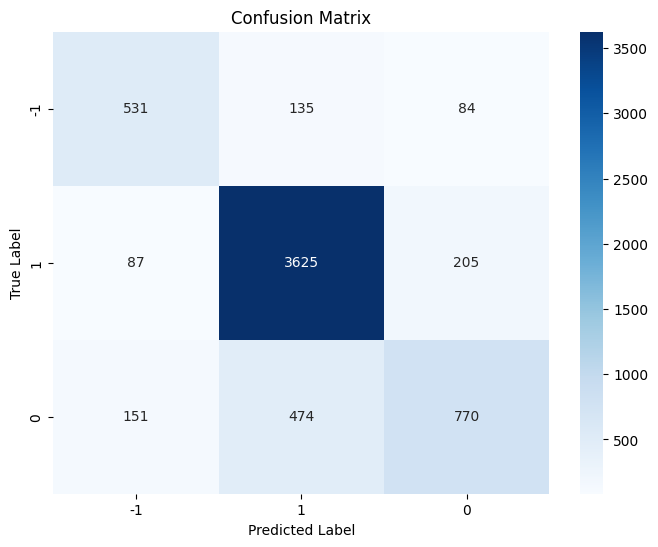

In [11]:
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=sentiments, yticklabels=sentiments)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [12]:
all_preds_np = np.array(all_preds)
all_labels_np = np.array(all_labels)

incorrect_indices = np.where(all_preds_np != all_labels_np)[0]

print(f"Number of incorrect predictions: {len(incorrect_indices)}")
print("\nExamples of incorrect predictions:")

num_examples_to_show = 10
for i in incorrect_indices[:num_examples_to_show]:
    original_text = test_df.iloc[i]['message']
    true_label_encoded = all_labels_np[i]
    predicted_label_encoded = all_preds_np[i]

    true_sentiment = id2sentiment[true_label_encoded]
    predicted_sentiment = id2sentiment[predicted_label_encoded]


    print(f"\nText: {original_text}")
    print(f"True Sentiment: {true_sentiment}, Predicted Sentiment: {predicted_sentiment}")

Number of incorrect predictions: 1136

Examples of incorrect predictions:

Text: 3Novices:Paris Climate Deal Weak, Unambitious: Centre For Science And Environment  The climate change agreement ado
True Sentiment: 0, Predicted Sentiment: 1

Text: Or global warming!
True Sentiment: -1, Predicted Sentiment: 0

Text: Invasive alien species are one of the biggest causes of biodiversity loss and species extinctions, but how is climate change comp
True Sentiment: 0, Predicted Sentiment: 1

Text: The same people who claimed there was a war on Christianity in America are attacking the pope over climate change:
True Sentiment: 1, Predicted Sentiment: -1

Text: Oh Leo just stole my heart with that long awaited acceptance. All about climate change! Well done sir! #oscars
True Sentiment: 1, Predicted Sentiment: 0

Text: How are you going to tell me that climate change/global warming isnt real...
True Sentiment: 0, Predicted Sentiment: 1

Text: Members voted 12-4 to approve new science standards aft

In [13]:
output_dir = "./bertweet-finetuned-pytorch"
loaded_tokenizer = AutoTokenizer.from_pretrained(output_dir)
loaded_model = AutoModelForSequenceClassification.from_pretrained(output_dir)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
loaded_model.to(device)

def predict_sentiment(text, model, tokenizer, device, id2sentiment):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=128)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    model.eval()
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)

    predicted_sentiment_id = predictions.item()
    predicted_sentiment = id2sentiment[predicted_sentiment_id]
    return predicted_sentiment

emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0


In [14]:
climate_text = "Climate change is a serious issue and we need to take action now to protect our planet."
prediction = predict_sentiment(climate_text, loaded_model, loaded_tokenizer, device, id2sentiment)
print(f"Text: '{climate_text}'\nPrediction: {prediction}")

Text: 'Climate change is a serious issue and we need to take action now to protect our planet.'
Prediction: 1


In [15]:
neutral_climate_text = "i think its okay"
prediction = predict_sentiment(neutral_climate_text, loaded_model, loaded_tokenizer, device, id2sentiment)
print(f"Text: '{neutral_climate_text}'\nPrediction: {prediction}")

Text: 'i think its okay'
Prediction: 0


In [16]:
negative_climate_text = "Climate change is a hoax and a waste of resources."
prediction = predict_sentiment(negative_climate_text, loaded_model, loaded_tokenizer, device, id2sentiment)
print(f"Text: '{negative_climate_text}'\nPrediction: {prediction}")

Text: 'Climate change is a hoax and a waste of resources.'
Prediction: -1


In [17]:
output_dir = "./bertweet-finetuned-pytorch"
zip_file_name = "bertweet_base_clean_dataset.zip"

In [18]:
!zip -r "{zip_file_name}" "{output_dir}"

  adding: bertweet-finetuned-pytorch/ (stored 0%)
  adding: bertweet-finetuned-pytorch/bpe.codes (deflated 58%)
  adding: bertweet-finetuned-pytorch/added_tokens.json (stored 0%)
  adding: bertweet-finetuned-pytorch/config.json (deflated 52%)
  adding: bertweet-finetuned-pytorch/special_tokens_map.json (deflated 57%)
  adding: bertweet-finetuned-pytorch/model.safetensors (deflated 12%)
  adding: bertweet-finetuned-pytorch/vocab.txt (deflated 51%)
  adding: bertweet-finetuned-pytorch/tokenizer_config.json (deflated 77%)


In [19]:
from google.colab import files

files.download(zip_file_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>